# 4) Data Quality & Robustness

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

np.random.seed(7)
n = 600
tickers = [f"U{i:04d}" for i in range(n)]
days = pd.date_range("2015-01-01","2020-12-31",freq="B")
prices = pd.DataFrame(index=days, columns=tickers, dtype=float)
levels = np.random.uniform(5,100,n)
for j,t in enumerate(tickers):
    r = np.random.normal(0.0004, 0.02, len(days))
    p = np.empty(len(days)); p[0]=levels[j]
    for i in range(1,len(days)):
        p[i] = max(0.5, p[i-1]*(1+r[i]))
    prices[t] = p

split_events = []
for t in tickers:
    if np.random.rand()<0.2:
        d = np.random.choice(days[200:-200])
        split=2
        split_events.append((d, t, split))
        idx = prices.index.get_loc(d)
        prices.loc[days>=d, t] /= split

dividends = []
for t in tickers:
    for _ in range(np.random.poisson(2)):
        d = np.random.choice(days[100:-100])
        dv = np.random.uniform(0.05,0.5)
        dividends.append((d,t,dv))

dead = set(np.random.choice(tickers, size=int(0.15*n), replace=False))
delist_date = {t: np.random.choice(days[800:-10]) for t in dead}
for t in dead:
    prices.loc[prices.index > delist_date[t], t] = np.nan


In [2]:
split_events[:5]

[(numpy.datetime64('2018-12-19T00:00:00.000000000'), 'U0000', 2),
 (numpy.datetime64('2017-12-13T00:00:00.000000000'), 'U0005', 2),
 (numpy.datetime64('2017-05-10T00:00:00.000000000'), 'U0008', 2),
 (numpy.datetime64('2016-10-31T00:00:00.000000000'), 'U0010', 2),
 (numpy.datetime64('2020-01-21T00:00:00.000000000'), 'U0015', 2)]

In [3]:
dividends[:5]

[(numpy.datetime64('2018-11-14T00:00:00.000000000'),
  'U0000',
  0.3593485998889876),
 (numpy.datetime64('2018-12-20T00:00:00.000000000'),
  'U0000',
  0.1918277291607292),
 (numpy.datetime64('2019-06-20T00:00:00.000000000'),
  'U0000',
  0.37017029572128646),
 (numpy.datetime64('2019-02-07T00:00:00.000000000'),
  'U0000',
  0.1812836327370072),
 (numpy.datetime64('2020-02-24T00:00:00.000000000'),
  'U0001',
  0.09239364339365745)]

## TODO Checklist
1. Build **back-adjusted prices** for splits and dividends.
2. Construct a **point-in-time universe** that includes delisted names (no survivorship bias).
3. Backtest a simple **12–1 momentum** strategy **before** and **after** cleaning; compare equity curves.
4. Document and print a small **data quality report** (rows dropped, reasons).


In [4]:
# sort by events from oldest to newest
split_events_sorted = pd.DataFrame(split_events).sort_values(by=[1, 0]).to_records(index=False)


In [5]:
dividends_sorted = pd.DataFrame(dividends).sort_values(by=[1, 0]).to_records(index=False)

In [6]:
# === TODO 1: Back-adjust prices ===
adj = prices.copy()
# for each split and dividend, back-adjust history
# TODO: implement

for d, t, split in split_events_sorted:
    adj.loc[adj.index < d, t] /= split
for d, t, dv in dividends_sorted:
    if t in adj:
        adj.loc[adj.index < d, t] += dv

In [ ]:
# === TODO 2: Point-in-time universe ===
# ret = adj.pct_change()
# TODO: assemble available universe each day (exclude NAs only that day)

In [ ]:
# === TODO 3: Backtest momentum before/after ===
# naive vs clean; compute cumulative returns and plot

In [7]:
ret_naive = prices.pct_change().fillna(0)
signal = prices.shift(21)/prices.shift(252) - 1
rank = signal.rank(axis=1, pct=True)
long = (rank > 0.9).astype(float)
short = (rank < 0.1).astype(float)
pnl_naive = (ret_naive * long - ret_naive * short).sum(axis=1)

/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_57975/954275114.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_naive = prices.pct_change().fillna(0)


In [8]:
ret_clean = adj.pct_change().fillna(0)
signal_clean = adj.shift(21)/adj.shift(252) - 1
rank_clean = signal_clean.rank(axis=1, pct=True)
long_clean = (rank_clean > 0.9).astype(float)
short_clean = (rank_clean < 0.1).astype(float)
pnl_clean = (ret_clean * long - ret_clean * short).sum(axis=1)

/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_57975/452765817.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_clean = adj.pct_change().fillna(0)


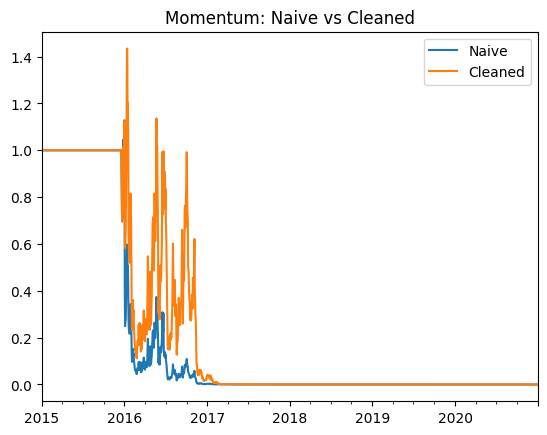

Splits: 136 Dividends: 1197 Delisted: 90
NA% before: 0.0351 NA% after: 0.0351


In [9]:
# === TODO 4: Data quality report ===
# print counts for splits, dividends, delistings, % of NAs handled, etc.
import matplotlib.pyplot as plt
plt.figure(); (1+pnl_naive).cumprod().plot(label="Naive"); (1+pnl_clean).cumprod().plot(label="Cleaned"); plt.title("Momentum: Naive vs Cleaned"); plt.legend(); plt.show()

print("Splits:", len(split_events), "Dividends:", len(dividends), "Delisted:", len(dead))
na_before = prices.isna().mean().mean()
na_after = adj.isna().mean().mean()
print("NA% before:", round(na_before,4), "NA% after:", round(na_after,4))